# AMME Data Processing

This notebook loads, processes, and epochs the Emory AMME datasets...

---
> Martina Hollearn (martina.hollearn@psych.utah.edu)  
> 05/13/24

## 1. Import Libraries

In [1]:
import os
import mne
import csv
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
from scipy.signal import filtfilt, firwin
import matplotlib.pyplot as plt


### Edit these paths for you PC:

In [8]:
# For Alireza's PC (Please don't revome the comments)
# rdDir = r'D:\Martina Test\Code'
# wrDir = r'D:\Martina Test\Code'

rdDir = r'D:\Martina Test\Code'
wrDir = r'D:\Martina Test\Code\JoesPreProcessRequiredFiles'

rdDir = os.path.normpath(rdDir)
wrDir = os.path.normpath(wrDir)

## 2. Load Data

In [3]:
subject = 'amyg003'
seeg_filename = f'{subject}_objectMemory_day2_05mA.edf'
file_path = rdDir
event_filename = f'{subject}_LFP_day2_trialtimes.mat'
log_filename = f'{subject}_day2.log'
data_path = os.path.join(file_path, subject, seeg_filename)
events_path = os.path.join(file_path, subject, event_filename)
logfile_path = os.path.join(file_path, subject, log_filename)

# Create Preprocessed data folder
preproc_datapath = os.path.join(file_path,subject,'PreprocessedData', 'Martinas_preprocessing')

if not os.path.exists(preproc_datapath):
    os.makedirs(preproc_datapath)

In [4]:
# Load SEEG data
raw = mne.io.read_raw_edf(data_path, preload=True)

# Get recording info
fs = int(np.round(raw.info['sfreq']))
ch_names = raw.info['ch_names']

# Set all channel types to SEEG
raw.set_channel_types({ch: 'seeg' for ch in ch_names})

# Display info
raw.info

Extracting EDF parameters from D:\Martina Test\Code\amyg003\amyg003_objectMemory_day2_05mA.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1637201  =      0.000 ...  1638.164 secs...


<Info | 8 non-empty values
 bads: []
 ch_names: Event, L1d1, L1d3, L1d5, L1d7, L1d9, L3d1, L3d4, L3d7, L5d1, ...
 chs: 129 sEEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 499.7 Hz
 meas_date: 2015-09-10 13:13:13 UTC
 nchan: 129
 projs: []
 sfreq: 999.4 Hz
 subject_info: <subject_info | his_id: Hishida,>
>

## 3. Initial Preprocessing steps


In [5]:
# Define your parameters
lowcut = 1  # Lower cutoff frequency
highcut = 119  # Upper cutoff frequency
transition_bandwidth = 1  # Transition bandwidth in Hz

# Dynamically get the subject's sampling rate
samprate = raw.info['sfreq']  # This pulls the sampling rate for the current subject

#Create a Copy and filter the data
proc_data = raw.copy()
proc_data.filter(lowcut, highcut, fir_design='firwin', filter_length='auto', phase='zero', fir_window='hamming', 
                 verbose=True,l_trans_bandwidth=1, h_trans_bandwidth=1)

#filter out 42 Hz noise
# proc_data.notch_filter(freqs = [42], picks='seeg', method='spectrum_fit', mt_bandwidth=3,verbose=True)# Joe had this in his code, not sure why it's there
# Apply notch filter (60, 120, 180 Hz)
# proc_data.notch_filter(freqs = [60], picks='seeg', method='spectrum_fit', mt_bandwidth=3,verbose=True)

proc_data.notch_filter(freqs = [42], picks='seeg')# Joe had this in his code, not sure why it's there
proc_data.notch_filter(freqs = [60], picks='seeg')

savemat(os.path.join(wrDir,'PythonPreprocessed.mat'), {'eeg_data': proc_data.get_data()})

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 119.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 119.50 Hz)
- Filter length: 3299 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    4.5s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 41 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 41.40
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 41.15 Hz)
- Upper passband edge: 42.60 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 42.85 Hz)
- Filter length: 6597 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    4.7s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6597 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    4.4s


## 4. Post Cleaning Preprocessing Steps
- Re-referencing (e.g., common median reference)
- Downsampling
- Epoching

In [7]:
# Call in previously dropped channels

preproc_datapath = r'D:\Martina Test\Code\JoesPreProcessRequiredFiles'
file_path = os.path.join(preproc_datapath,'DroppedChans.csv')
print(file_path)

dropped_chans = []

with open(file_path, "r") as file:
    reader = csv.reader(file)
    for row in reader:
        dropped_chans.append(row[1])
       
dropped_chans = dropped_chans[1:]
dropped_chans = list(filter(None, dropped_chans))  # Remove empty strings

print(dropped_chans)

D:\Martina Test\Code\JoesPreProcessRequiredFiles\DroppedChans.csv
['Event', 'RPTs5']


In [ ]:
proc_data.info
bads = dropped_chans
proc_data = proc_data.drop_channels(bads)
proc_data.info

<Info | 8 non-empty values
 bads: []
 ch_names: L1d1, L1d3, L1d5, L1d7, L1d9, L3d1, L3d4, L3d7, L5d1, L5d4, ...
 chs: 127 sEEG
 custom_ref_applied: False
 highpass: 1.0 Hz
 lowpass: 119.0 Hz
 meas_date: 2015-09-10 13:13:13 UTC
 nchan: 127
 projs: []
 sfreq: 999.4 Hz
 subject_info: <subject_info | his_id: Hishida,>
>

In [10]:
savedProcData = proc_data.copy() 

In [11]:
# Re-referencing
proc_data_ref = proc_data.get_data()  # Convert to numpy array
median_lfp = np.median(proc_data_ref, axis=0)  # Calculate median LFP
proc_data_ref = proc_data_ref - median_lfp  # Subtract median LFP for re-referencing
proc_data = mne.io.RawArray(proc_data_ref, proc_data.info)  # Convert back to MNE object

savemat(os.path.join(wrDir,'PythonPP_MedianRemoved.mat'), {'eeg_data': proc_data.get_data()})
# Downsampling
fs = 500
proc_data = proc_data.resample(sfreq=fs)

savemat(os.path.join(wrDir,'PythonPPMR_ReSampled.mat'), {'eeg_data': proc_data.get_data()})

Creating RawArray with float64 data, n_channels=127, n_times=1637202
    Range : 0 ... 1637201 =      0.000 ...  1638.164 secs
Ready.


### Load in trial times from matlab file, filter by response types for remembered and forgotten images (filter out new images)

In [14]:
datapath = r'D:\Martina Test\Code\amyg003'
subject = 'amyg003'
event_filename = f'{subject}_LFP_day2_trialtimes.mat'
events_path = os.path.join(datapath, event_filename)
print(events_path)

events = loadmat(events_path, simplify_cells=True)
day2_trial_times = events['day2_trial_times']
day2_trial_times = day2_trial_times * fs # convert to samples
day2_trial_times = np.array([int(np.round(x)) for x in day2_trial_times]) # round to nearest integer
print('lenght of day2_trial_times:',len(day2_trial_times))
print("Remaining length of day2_trial_times:", len(day2_trial_times))

D:\Martina Test\Code\amyg003\amyg003_LFP_day2_trialtimes.mat
lenght of day2_trial_times: 120
Remaining length of day2_trial_times: 120


In [18]:
n_events = len(day2_trial_times)
(print(n_events))
events_array = np.zeros((n_events, 3), dtype=int)
print(events_array.shape)
events_array[:, 0] = day2_trial_times
print(proc_data.get_data().shape)

120
(120, 3)
(127, 819083)


### Epoch data 

Not setting metadata
120 matching events found


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 5001 original time points ...
0 bad epochs dropped
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.
Using data from preloaded Raw for 20 events and 5001 original time points ...


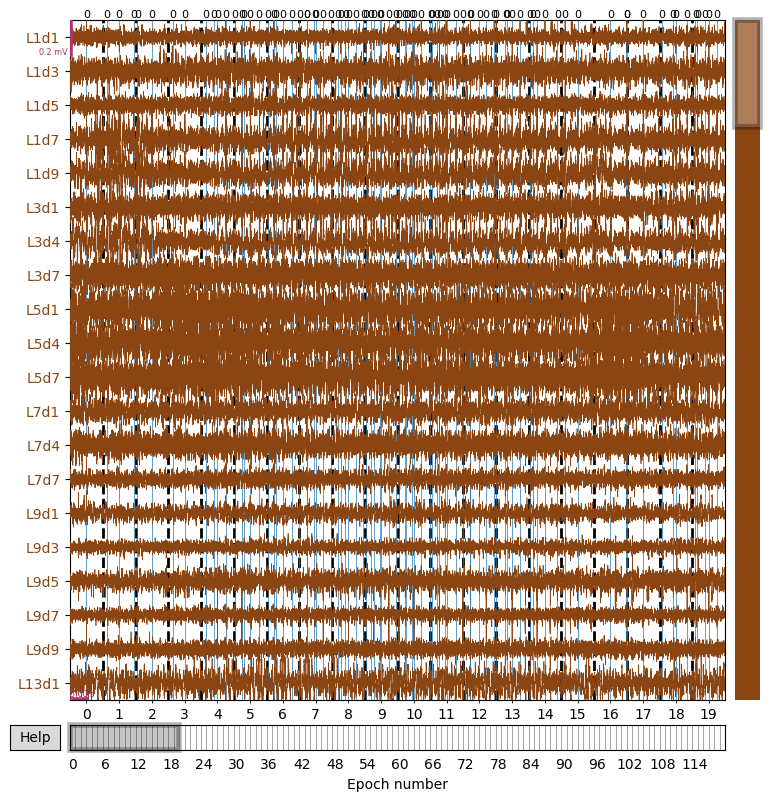

num events 120
num epochs 120


In [ ]:
# Epoching
epochs = mne.Epochs(proc_data, events_array, tmin = -5, tmax = 5, baseline = None, reject=None) # 5s before to 5s after event onset
epochs.plot(title='Epoched EEG Data', block=True, events=events_array)

# savemat(os.path.join(wrDir,'PythonPreprocessed.mat'), {'eeg_data': proc_data.get_data()})
print('num events',events_array.shape[0])
print('num epochs',len(epochs))


<Info | 8 non-empty values
 bads: []
 ch_names: L1d1, L1d3, L1d5, L1d7, L1d9, L3d1, L3d4, L3d7, L5d1, L5d4, ...
 chs: 127 sEEG
 custom_ref_applied: False
 highpass: 1.0 Hz
 lowpass: 119.0 Hz
 meas_date: 2015-09-10 13:13:13 UTC
 nchan: 127
 projs: []
 sfreq: 500.0 Hz
 subject_info: <subject_info | his_id: Hishida,>
>

In [27]:
info = epochs.info
info_list = [info['sfreq'], info['nchan'], info['ch_names'], info['chs'], info['events'],  info['lowpass'], info['highpass'], info['proc_history'], info['subject_info']]
info_array = np.array(info_list, dtype=object)
print(info_array)

[500.0 127
 list(['L1d1', 'L1d3', 'L1d5', 'L1d7', 'L1d9', 'L3d1', 'L3d4', 'L3d7', 'L5d1', 'L5d4', 'L5d7', 'L7d1', 'L7d4', 'L7d7', 'L9d1', 'L9d3', 'L9d5', 'L9d7', 'L9d9', 'L13d1', 'L13d2', 'L13d3', 'L13d4', 'L13d5', 'L13d6', 'L13d7', 'L13d8', 'L13d9', 'L13d10', 'L15d1', 'L15d2', 'L15d3', 'L15d4', 'L15d5', 'L15d6', 'L15d7', 'L15d8', 'L15d9', 'L15d10', 'L17d1', 'L17d4', 'L17d7', 'L19d1', 'L19d4', 'L19d7', 'L19d10', 'LFPs1', 'LFPs3', 'LFPs5', 'LFPs7', 'LFPs9', 'LSFs1', 'LSFs3', 'LSFs5', 'LIFs1', 'LIFs3', 'LIFs5', 'LIFs7', 'LATs1', 'LATs3', 'LATs5', 'LATs7', 'LATs9', 'LPTs1', 'LPTs3', 'LPTs5', 'R2d1', 'R2d3', 'R2d5', 'R2d7', 'R2d9', 'R4d1', 'R4d4', 'R4d7', 'R6d1', 'R6d4', 'R6d7', 'R8d1', 'R8d4', 'R8d7', 'R10d1', 'R10d3', 'R10d5', 'R10d7', 'R10d9', 'R12d1', 'R12d4', 'R12d7', 'R14d1', 'R14d2', 'R14d3', 'R14d4', 'R14d5', 'R14d6', 'R14d7', 'R14d8', 'R14d9', 'R14d10', 'R16d1', 'R16d2', 'R16d3', 'R16d4', 'R16d5', 'R16d6', 'R16d7', 'R16d8', 'R16d9', 'R16d10', 'R18d1', 'R18d4', 'R18d7', 'R20d1', 'R

In [ ]:

savemat(os.path.join(wrDir,'PythonPPMRRS_Epoched.mat'), {'eeg_data': epochs.get_data(),'Info':info_array})

Using data from preloaded Raw for 120 events and 5001 original time points ...


## 5. Export the data into numpy arrays for analysis

In [ ]:
# Get raw data, list of rejected epochs, list of bad_chans
epoch_data = epochs.get_data()
drop_epochs = [n for n, dl in enumerate(epochs.drop_log) if len(dl)]
events_mask = np.ones(events_array.shape[0], dtype = bool)
events_mask[drop_epochs] = False #drop epochs from events array
keep_events = events_array[events_mask] 

# Export dropped epochs, dropped chans, events, and channel labels to .csv files
np.save(os.path.join(preproc_datapath, ('PreprocessedData')), epoch_data)
np.save(os.path.join(preproc_datapath, ('Events')), keep_events) #saves only the epochs that were not dropped manually
pd.DataFrame(drop_epochs, columns = ['Dropped Epochs']).to_csv(os.path.join(preproc_datapath,'DroppedEpochs.csv'))
pd.DataFrame(bads, columns = ['Dropped Chans']).to_csv(os.path.join(preproc_datapath,'DroppedChans.csv'))
pd.DataFrame(epochs.ch_names, columns = ['Chan']).to_csv(os.path.join(preproc_datapath,'ChanLabels.csv'))

In [ ]:
a = np.load(os.path.join(preproc_datapath, ('Events.npy')))